## Load modules and data

In [1]:
#Base
from os import path
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
from statsmodels.stats.multitest import fdrcorrection
import ray

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis.correlation import calculate_correlation, ProgressBar
import allen_v1dd.stimulus_analysis.analysis_tools as at
import allen_v1dd.stimulus_analysis.decoding as dc


#Network 
import networkx as nx
import networkx.algorithms.community as nx_comm
from networkx.algorithms.community import greedy_modularity_communities, naive_greedy_modularity_communities
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

In [2]:
metrics_all = at.load_roi_metrics(metrics_file='~/Git/allen_v1dd/data_frames/v1dd_metrics.csv',add_columns=True, remove_invalid=False, remove_duplicates=False)

# Only consider valid metrics
n_before = len(metrics_all)
metrics_13 = metrics_all[metrics_all.is_valid & (metrics_all.mouse == 409828) & (metrics_all.column == 1) & (metrics_all.volume == 3)]
print(f"Only considering valid ROIs in M409828, col-1,vol-3: {len(metrics_13)} / {n_before} ({len(metrics_13)/n_before*100:.1f}%)")

metrics_13

Only considering valid ROIs in M409828, col-1,vol-3: 2708 / 52826 (5.1%)


,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_13_1_0,409828,1,3,1,0,True,False,True,2,"M409828_13_1_0, M409828_13_2_214",...,0.000429,0.002773,4,200,3-1,False,False,0.175127,19.837932,348.091708
M409828_13_1_1,409828,1,3,1,1,True,False,True,2,"M409828_13_1_1, M409828_13_2_35",...,0.000567,0.003633,4,200,3-1,False,False,0.218124,0.948082,314.819042
M409828_13_1_2,409828,1,3,1,2,True,False,False,0,NaN,...,0.000964,0.005869,4,200,3-1,False,False,0.182812,295.150372,126.913790
M409828_13_1_3,409828,1,3,1,3,True,False,True,2,"M409828_13_1_3, M409828_13_2_65",...,0.000782,0.005164,4,200,3-1,False,False,0.125851,131.588545,71.779196
M409828_13_1_4,409828,1,3,1,4,True,False,False,0,NaN,...,0.000886,0.006152,4,200,3-1,False,False,0.032789,275.427907,232.816749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,True,False,False,0,NaN,...,0.000425,0.002841,5,300,3-6,True,False,0.362698,73.038353,98.387835
M409828_13_6_722,409828,1,3,6,722,True,False,False,0,NaN,...,0.000360,0.002641,5,300,3-6,True,False,0.524505,246.541605,56.632700
M409828_13_6_723,409828,1,3,6,723,True,False,False,0,NaN,...,0.000615,0.003767,5,300,3-6,False,False,0.044187,58.405604,18.263005
M409828_13_6_776,409828,1,3,6,776,True,False,False,0,NaN,...,0.000598,0.004100,5,300,3-6,False,False,0.061579,19.067217,69.325038


In [3]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)



In [4]:
##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [5]:
## Interpolate all planes to same time
data_list_interp = sess.interpolate_all_plane_traces_to_common_time_series(trace_type='dff',reload=True)

#Get stimulus times for natural images
stim_table, stim_meta = sess.get_stimulus_table("natural_images_12")

#Get start and end times for stimulus type
tStart = stim_table.start.values[0]
tEnd = stim_table.end.values[-1]
print(f"start={tStart}, end={tEnd}")

data_list = []
for data_xarr in data_list_interp:
    data_list.append(data_xarr.sel(time=slice(tStart-32/6,tEnd+32/6)))

ts = data_list[0].coords['time'].values

# event_traces = np.concatenate(data_list)
dF_traces = np.concatenate(data_list)

#Get number of neurons per plane
nNeurons_plane = [len(t) for t in data_list_interp]
nNeurons_plane



start=1179.5711669921875, end=1331.68115234375


[409, 470, 483, 478, 438, 430]

In [6]:
ts_naturalscenes = data_list[0].coords['time'].values
roi_list = [data.coords['roi'].values for data in data_list_interp]

In [7]:
np.save(f'../data_frames/dff_naturalscenes_{mouse_id}_{col}{vol}.npy',dF_traces)

In [8]:
f'../data_frames/dff_naturalscenes_{mouse_id}_{col}{vol}.npy'

'../data_frames/dff_naturalscenes_409828_13.npy'

In [7]:
#Read in CASCADE deconvolution results
spike_prob = np.load(f'../data_frames/predictions_dff_naturalscenes_{mouse_id}_{col}{vol}.npy')
spike_prob.shape

(2708, 987)

In [10]:
nSpkCounts = np.sum(dF_traces,axis=1)
maxFR_neurons = np.argsort(nSpkCounts)[::-1]
maxFR_neurons

array([1093, 1074,  907, ..., 1491,  445,  341])

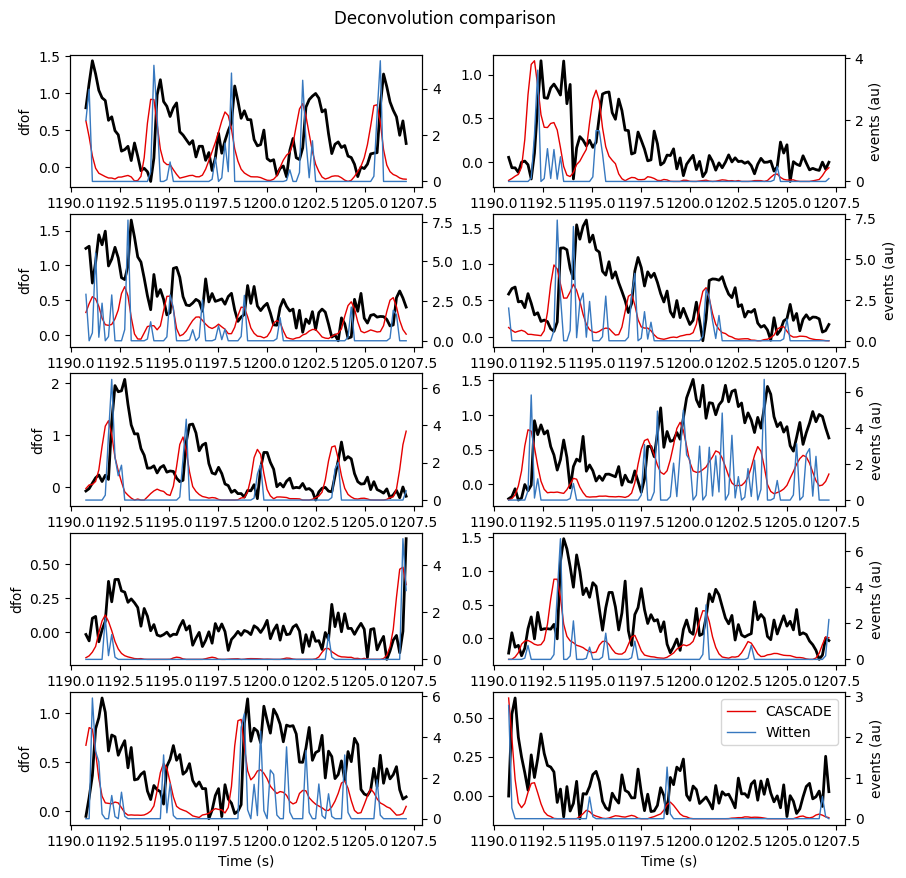

In [13]:
fig, axes = plt.subplots(5,2,figsize=(10,10))
plt.suptitle('Deconvolution comparison',y=0.925)
plotslice = slice(100,200)
for ii, iN in enumerate(maxFR_neurons[:10]):
    ax = axes[ii//2,ii%2]

    ax1 = ax.twinx()

    y = spike_prob[iN]; yz= y/np.nanstd(y)
    ax1.plot(ts[plotslice],yz[plotslice],'-',color=cc[1],label='CASCADE',lw=1)
    y = event_traces[iN]; yz= y/np.nanstd(y)
    ax1.plot(ts[plotslice],yz[plotslice],'-',color=cc[2],label='Witten',lw=1)

    ax.plot(ts[plotslice],dF_traces[iN,plotslice],'-k',lw=2)

    if ii%2 == 0:
        ax.set_ylabel('dfof')
    else:
        ax1.set_ylabel('events (au)')
    
    if ii//2 == 4:
        ax.set_xlabel('Time (s)')
ax1.legend()

# plt.savefig(path.join(PlotDir,f'deconvolution_compare_{mouse_id}_{col}{vol}.pdf'))


In [8]:
boundaries =  np.concatenate(([0],np.cumsum(nNeurons_plane)))
spike_prob_list = [spike_prob[boundaries[i]:boundaries[i+1],33:-32] for i in range(6)]
ts = ts_naturalscenes[33:-32]
#Make array into x-array again
spike_prob_xlist = []
for rois, data in zip(roi_list,spike_prob_list):
    # Save in cache
    traces = xr.DataArray(
        data,
        name='spike_probability',
        dims=("roi", "time"),
        coords=dict(roi=rois, time=ts)
    )
    spike_prob_xlist.append(traces)


In [10]:

def find_nearest(trace: np.ndarray, value: float, direction: int=0) -> int:
    """Return the index in trace of the element that is closest to value.
    Args:
        trace (np.ndarray): Trace to search in
        value (float): Value to search for
        direction (int, optional): Direction to search: 0 = all elements; 1 = only elements >= value; -1 = only elements <= value. Defaults to 0.
    Raises:
        ValueError: If direction is invalid.
    Returns:
        int: Index in trace of closest element to value, or None if no elements match search.
    """
    # First search in array
    find = np.where(trace == value)[0]
    if len(find) > 0:
        return find[0]

    diff = (trace - value).astype(np.float32)

    if direction == -1:
        # Ignore elements that are larger than value
        diff[trace > value] = np.nan
    elif direction == 1:
        # Ignore elements that are smaller than value
        diff[trace < value] = np.nan
    elif direction == 0:
        pass
    else:
        raise ValueError(f"direction should be 0, 1, or -1 (given {direction}).")

    diff = np.abs(diff)

    if np.isnan(diff).all():
        return None
    else:
        return np.nanargmin(diff)

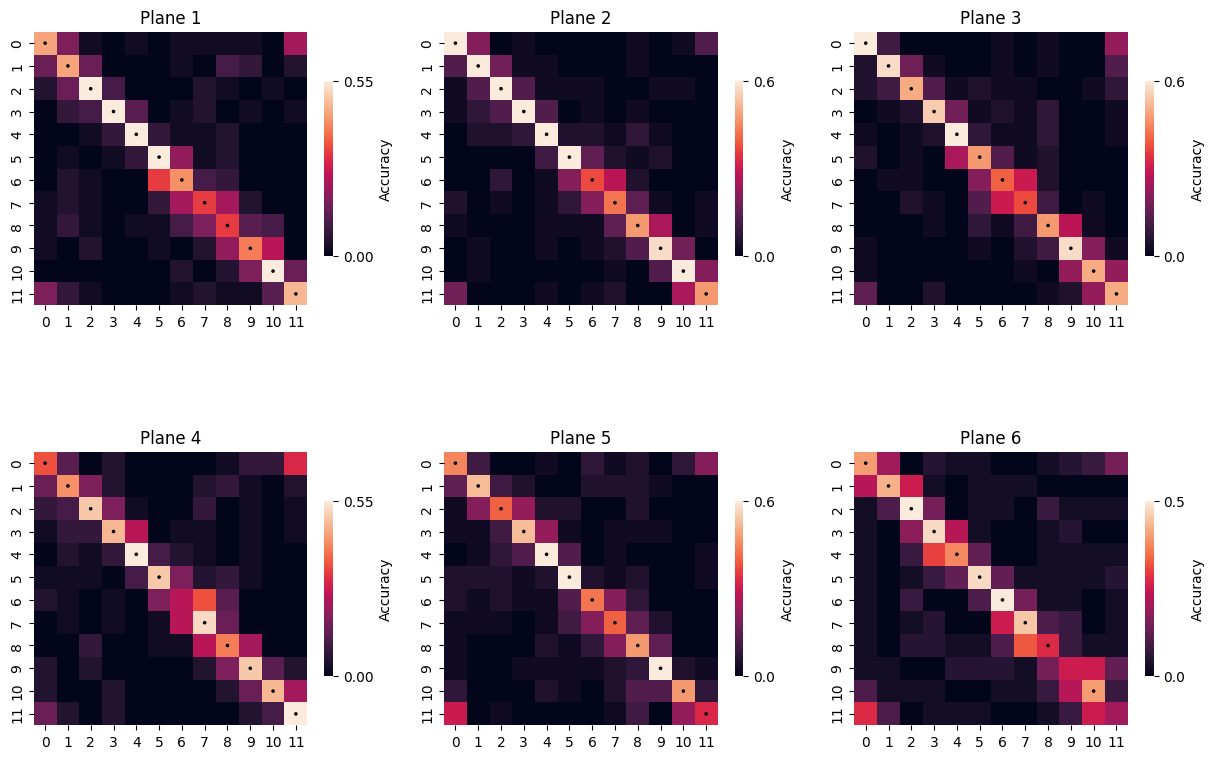

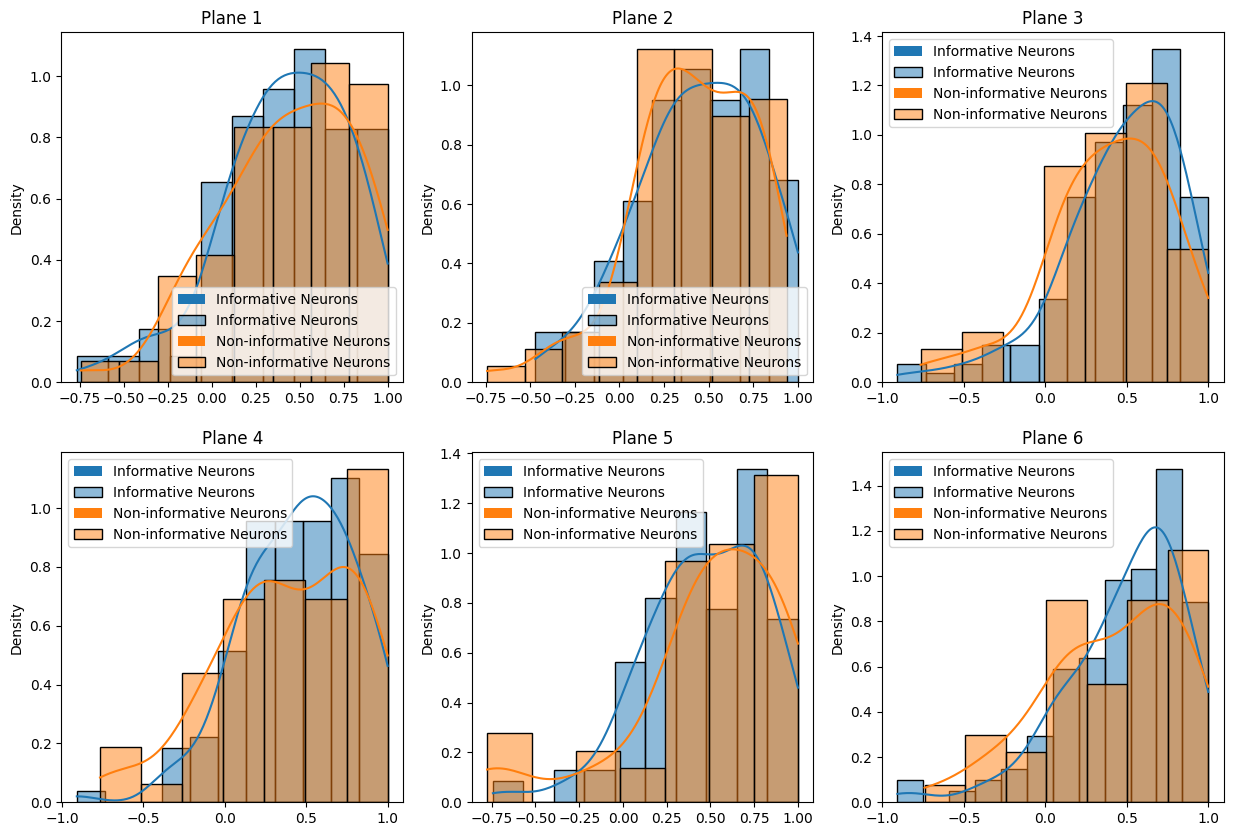

In [56]:
classifier = 'SVM'
method = 'kfold'
dim_reduce = False
ts = ts_naturalscenes[33:-32]

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
fig2, axes2 = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

ssi_informative_neurons = []; ssi_non_list = []; results_list = []
##===== Perform decoding of natural images per plane =====##
for ii, data in enumerate(spike_prob_list):
    # plane = 1

    ax = axes[ii//3,ii%3]#; ax.axis('off')
    ax.set_title(f'Plane {ii+1}')

    resp_list = []
    for index, row in stim_table.iterrows():
        tStart = row.start; tEnd = row.end

        iStart = find_nearest(ts, tStart)
        iEnd = find_nearest(ts, tEnd)
        # import pdb; pdb.set_trace()
        #Average response over window (usually just 2 bins)
        response = np.mean(data[:,slice(iStart,iEnd)],axis=1)
        resp_list.append(response)

    X = np.array(resp_list,dtype='float64')
    Y = stim_table['image'].values

    if dim_reduce:
        pca = PCA(n_components=0.99)
        X_pca = pca.fit_transform(X)
        nComponents_pca = X_pca.shape[-1]
        print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))
        confusion_mat, confusion_shf, confusion_z,pvalues, decoding_weights, decoding_weights_z = dc.cross_validate(X_pca, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)


    confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z  = dc.cross_validate(X, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=ax)
    results_list.append((confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z))
    nKfold, nStim, nNeurons = decoding_weights.shape
    informative_neurons_kfold = []
    
    for jj in range(nKfold):
        dw = np.array(decoding_weights_z[jj]).T

        #Get elements whose z-score is larger than abs(z) > 2
        mask = (dw > 1.5) | (dw < -1.5)

        #Define informative neurons as those that help decoding of at least 1 image
        informative_neurons = np.where(np.sum(mask,axis=1) > 0)[0]
        informative_neurons_kfold.append(informative_neurons)

    ## How do we take these decoding weights to ascertain which neurons are informative for decoding?
    from functools import reduce
    informative_neurons_indices = reduce(np.intersect1d, (informative_neurons_kfold))

    # informative_neurons_indices = np.unique(np.concatenate(informative_neurons_kfold))
    noninformative_neurons_indices = np.setdiff1d(np.arange(nNeurons),informative_neurons)


    ssi_list = []

    roiIDs = roi_list[ii]
    for index in informative_neurons_indices:
        iN = roiIDs[index]
        key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
        if key not in metrics_13.index.values:
            continue
        ssi_list.append(metrics_13.loc[key]['ssi'])
        
    ssi_list2 = []

    roiIDs = roi_list[ii]
    for index in noninformative_neurons_indices:
        iN = roiIDs[index]
        key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
        if key not in metrics_13.index.values:
            continue
        ssi_list2.append(metrics_13.loc[key]['ssi'])  
        # print(metrics_13.loc[key]['dgw_frac_responsive_trials'],metrics_13.loc[key]['dgf_frac_responsive_trials'],metrics_13.loc[key]['ssi'])

    ssi_informative_neurons.extend(ssi_list); ssi_non_list.extend(ssi_list2)
    ax = axes2[ii//3,ii%3]#; ax.axis('off')
    ax.set_title(f'Plane {ii+1}')
    # fig, ax = plt.subplots(figsize=(10,7))
    b1 = sns.histplot(ssi_list,ax=ax,stat='density',kde=True,label='Informative Neurons')
    b2 = sns.histplot(ssi_list2,ax=ax,stat='density',kde=True,label='Non-informative Neurons')

    ax.legend()


        
    


In [77]:
results_list

[(array([[0.45 , 0.175, 0.025, 0.   , 0.025, 0.   , 0.025, 0.025, 0.025,
          0.025, 0.   , 0.225],
         [0.15 , 0.45 , 0.15 , 0.   , 0.   , 0.   , 0.025, 0.   , 0.1  ,
          0.075, 0.   , 0.05 ],
         [0.05 , 0.15 , 0.6  , 0.1  , 0.   , 0.   , 0.   , 0.05 , 0.025,
          0.   , 0.025, 0.   ],
         [0.   , 0.075, 0.1  , 0.575, 0.125, 0.   , 0.025, 0.05 , 0.   ,
          0.025, 0.   , 0.025],
         [0.   , 0.   , 0.025, 0.075, 0.725, 0.075, 0.025, 0.025, 0.05 ,
          0.   , 0.   , 0.   ],
         [0.   , 0.025, 0.   , 0.025, 0.075, 0.6  , 0.2  , 0.025, 0.05 ,
          0.   , 0.   , 0.   ],
         [0.   , 0.05 , 0.025, 0.   , 0.   , 0.325, 0.425, 0.1  , 0.075,
          0.   , 0.   , 0.   ],
         [0.025, 0.05 , 0.025, 0.   , 0.   , 0.075, 0.225, 0.325, 0.225,
          0.05 , 0.   , 0.   ],
         [0.025, 0.075, 0.025, 0.   , 0.025, 0.025, 0.1  , 0.175, 0.325,
          0.125, 0.1  , 0.   ],
         [0.025, 0.   , 0.05 , 0.   , 0.   , 0.025, 0. 

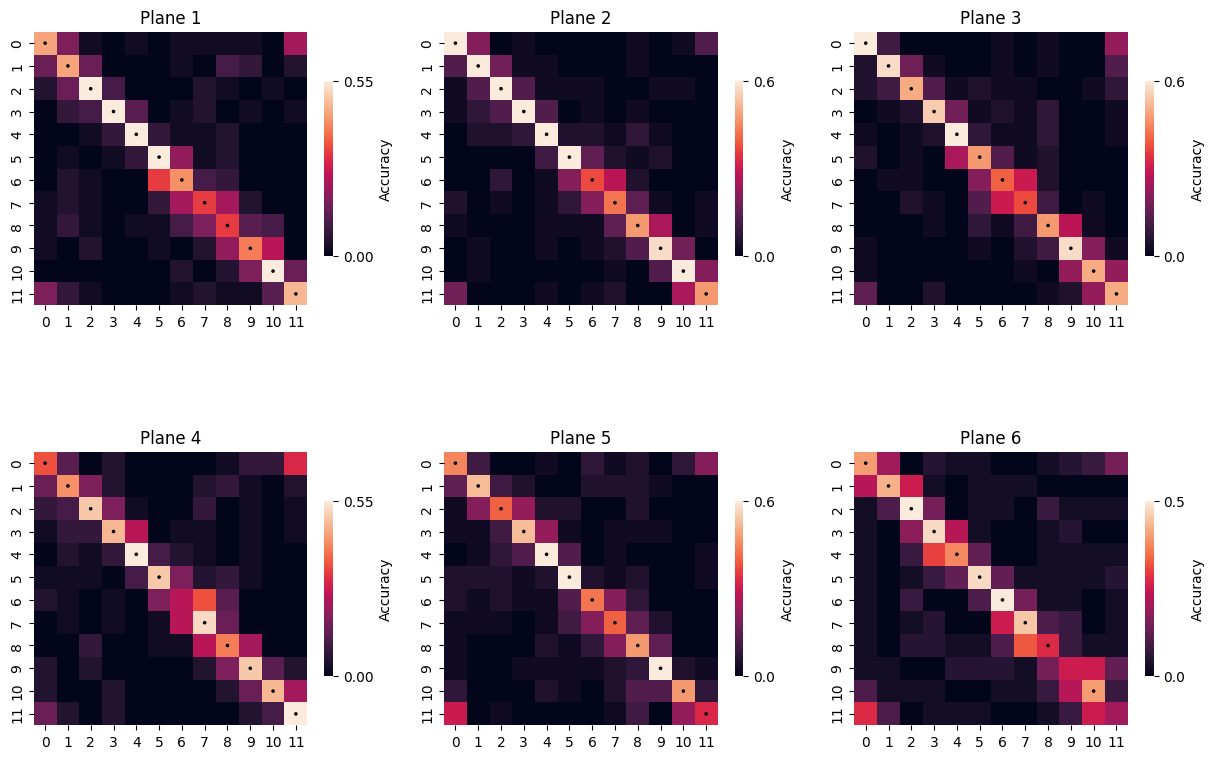

In [79]:
fig2, axes2 = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))


for ii, rtuple in enumerate(results_list):
    confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z = rtuple
    
    dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=axes2[ii//3,ii%3])
    axes2[ii//3,ii%3].set_title(f'Plane {ii+1}')
fig2.savefig(path.join(PlotDir,f'decoding_naturalscenes_{mouse_id}_{col}{vol}.pdf'))
    

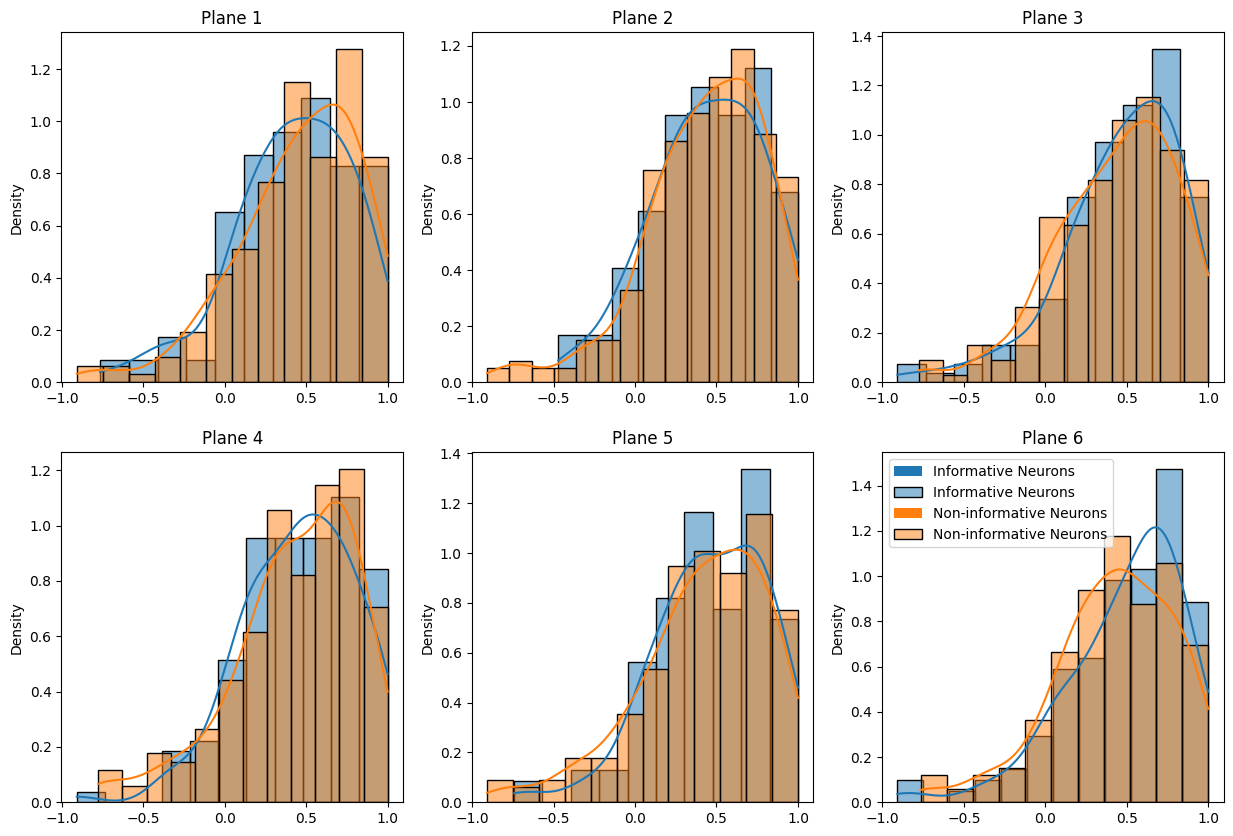

In [80]:
fig2, axes2 = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

ssi_informative_neurons = []; ssi_non_list = []
for ii, rtuple in enumerate(results_list):
    confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z = rtuple
    
    nKfold, nStim, nNeurons = decoding_weights.shape
    informative_neurons_kfold = []
    
    for jj in range(nKfold):
        dw = np.array(decoding_weights_z[jj]).T

        #Get elements whose z-score is larger than abs(z) > 2
        mask = (dw > 1.5) | (dw < -1.5)

        #Define informative neurons as those that help decoding of at least 1 image
        informative_neurons = np.where(np.sum(mask,axis=1) > 0)[0]
        informative_neurons_kfold.append(informative_neurons)

    ## How do we take these decoding weights to ascertain which neurons are informative for decoding?
    from functools import reduce
    informative_neurons_indices = reduce(np.intersect1d, (informative_neurons_kfold))

    # informative_neurons_indices = np.unique(np.concatenate(informative_neurons_kfold))
    noninformative_neurons_indices = np.setdiff1d(np.arange(nNeurons),informative_neurons_indices)
    

    ssi_list = []

    roiIDs = roi_list[ii]
    for index in informative_neurons_indices:
        iN = roiIDs[index]
        key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
        if key not in metrics_13.index.values:
            continue
        ssi_list.append(metrics_13.loc[key]['ssi'])
        
    ssi_list2 = []

    roiIDs = roi_list[ii]
    for index in noninformative_neurons_indices:
        iN = roiIDs[index]
        key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
        if key not in metrics_13.index.values:
            continue
        ssi_list2.append(metrics_13.loc[key]['ssi'])  
        # print(metrics_13.loc[key]['dgw_frac_responsive_trials'],metrics_13.loc[key]['dgf_frac_responsive_trials'],metrics_13.loc[key]['ssi'])

    ssi_informative_neurons.extend(ssi_list); ssi_non_list.extend(ssi_list2)
    ax = axes2[ii//3,ii%3]#; ax.axis('off')
    ax.set_title(f'Plane {ii+1}')
    # fig, ax = plt.subplots(figsize=(10,7))
    b1 = sns.histplot(ssi_list,ax=ax,stat='density',kde=True,label='Informative Neurons')
    b2 = sns.histplot(ssi_list2,ax=ax,stat='density',kde=True,label='Non-informative Neurons')

    if ii == 5:
        ax.legend()
    fig2.savefig(path.join(PlotDir,'SSIvsDecodingWeights_zthreshold1.5.pdf'))
    

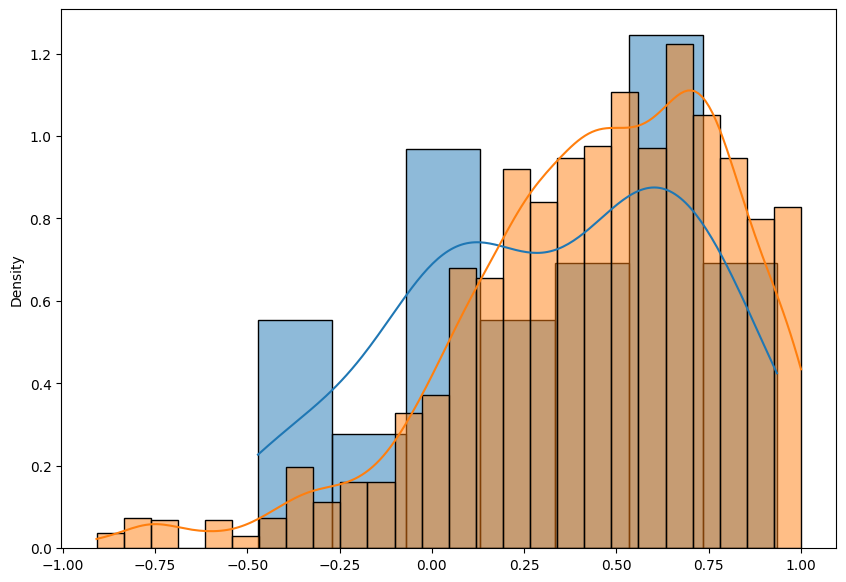

In [75]:
fig, ax = plt.subplots(figsize=(10,7))
b1 = sns.histplot(ssi_informative_neurons,ax=ax,stat='density',kde=True,label='Informative Neurons')
b2 = sns.histplot(ssi_non_list,ax=ax,stat='density',kde=True,label='Non-informative Neurons')

# fig2.savefig(path.join(PlotDir,'SSIvsDecodingWeights_zthreshold2.pdf'))

## If we look at just one plane for now

In [11]:
classifier = 'SVM'
method = 'kfold'
plane = 2

data = spike_prob_list[plane-1]
ts = ts_naturalscenes[33:-32]

resp_list = []
for index, row in stim_table.iterrows():
    tStart = row.start; tEnd = row.end

    iStart = find_nearest(ts, tStart)
    iEnd = find_nearest(ts, tEnd)

    #Average response over window (usually just 2 bins)
    response = np.mean(data[:,slice(iStart,iEnd)],axis=1)
    resp_list.append(response)

X = np.array(resp_list,dtype='float64')
Y = stim_table['image'].values

nTrials, nNeurons = X.shape


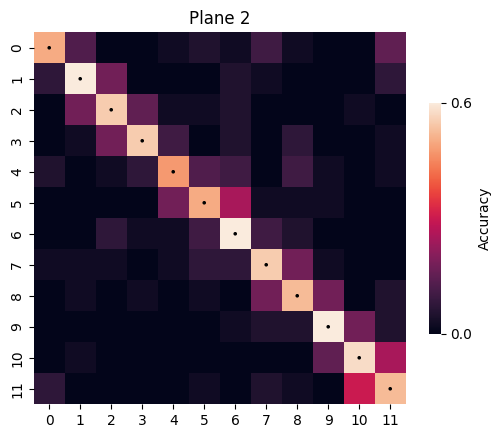

In [12]:
classifier = 'SVM'
method = 'kfold'

fig, ax = plt.subplots(figsize=(6,6))
ax.set_title(f'Plane {plane}')

confusion_mat, confusion_shf, confusion_z, pvalues, decoding_weights, decoding_weights_z = dc.cross_validate(X, Y, classifier=classifier, method=method, shuffle=True, plot_shuffle=False, parallel=False)
dc.plot_decoding_accuracy(confusion_mat,confusion_z,annot=False,ax=ax)
    


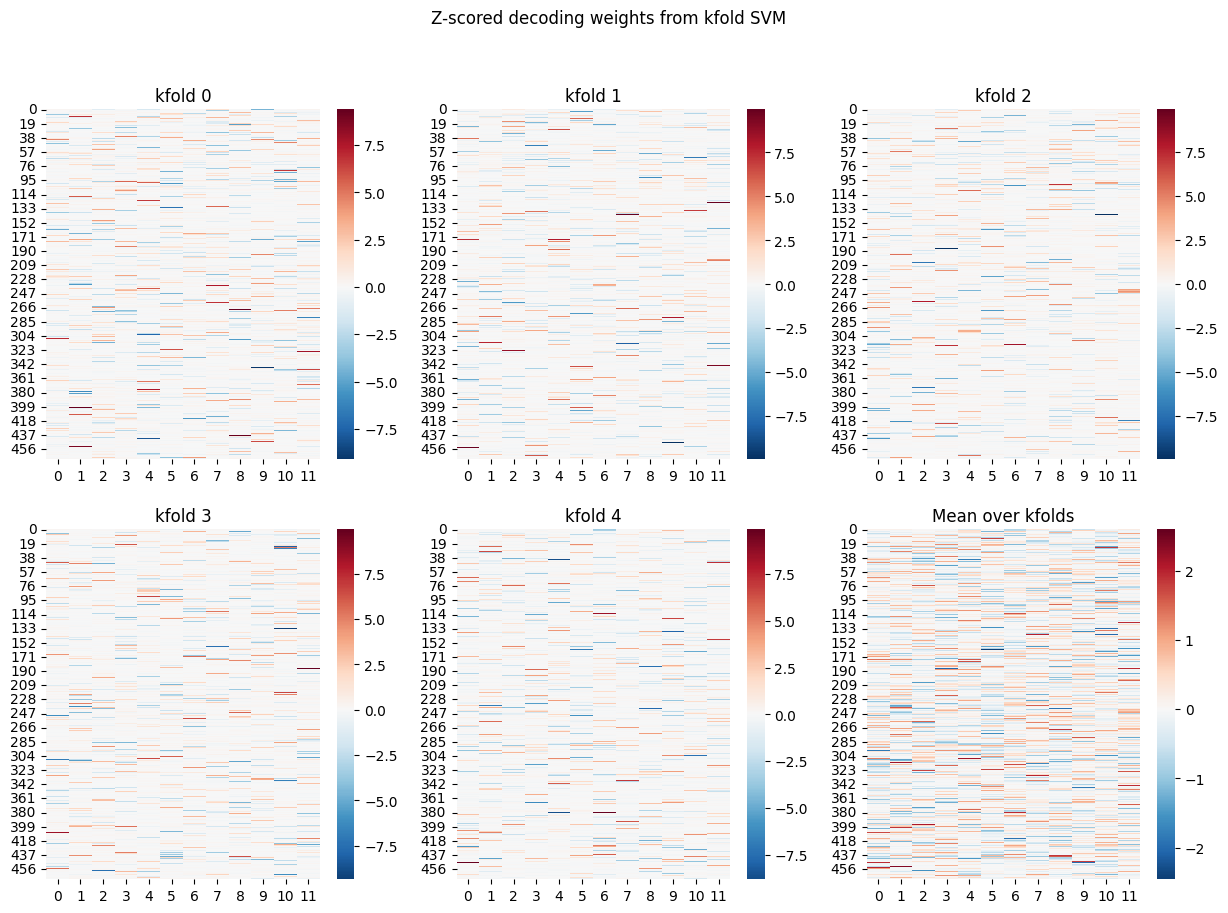

In [13]:
unique_stimIDs = [29,  4, 23, 32,  9, 47, 68, 62, 27,  6,  2,  5]
nStim = 12

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
plt.suptitle(f'Z-scored decoding weights from {method} {classifier}')
informative_neurons_kfold = []
neurons_numimgs = []
##===== Perform decoding of natural images per plane =====##
for ii in range(6):
    ax = axes[ii//3,ii%3]#; ax.axis('off')
    if ii == 5:
        dw = np.mean(decoding_weights_z,axis=0).T
        ax.set_title('Mean over kfolds')
    else:
        dw = np.array(decoding_weights_z[ii]).T
        ax.set_title(f'kfold {ii}')
    
    if ii % 3 == 0:
        ax.set_ylabel('Neurons')

    if ii//3 == 1:
        ax.set_xlabel('Stimulus ID')
        ax.set_xticks(np.arange(nStim))
        ax.set_xticklabels(unique_stimIDs)

    sns.heatmap(dw,ax=ax,cmap='RdBu_r',center=0)#,mask=~mask)
    if ii == 5:
        continue

    #Get elements whose z-score is larger than abs(z) > 2
    mask = (dw > 1.5) | (dw < -1.5)

    #Define informative neurons as those that help decoding of at least 1 image
    informative_neurons = np.where(np.sum(mask,axis=1) > 0)[0]
    informative_neurons_kfold.append(informative_neurons)
    
    neurons_numimgs.append(np.sum(mask,axis=1))

plt.savefig(path.join(PlotDir,f'dwz_naturalscences_{method}{classifier}_l1_{mouse_id}_{col}{vol}.pdf'))


In [18]:
ssi_list = []
for plane in range(1,7):
    sub_df = metrics_13.loc[metrics_13.plane == plane]
    ssi_list.append(sub_df['ssi'].values)
    print(len(sub_df))

409
470
483
478
438
430


In [19]:
dw.shape

(470, 12)

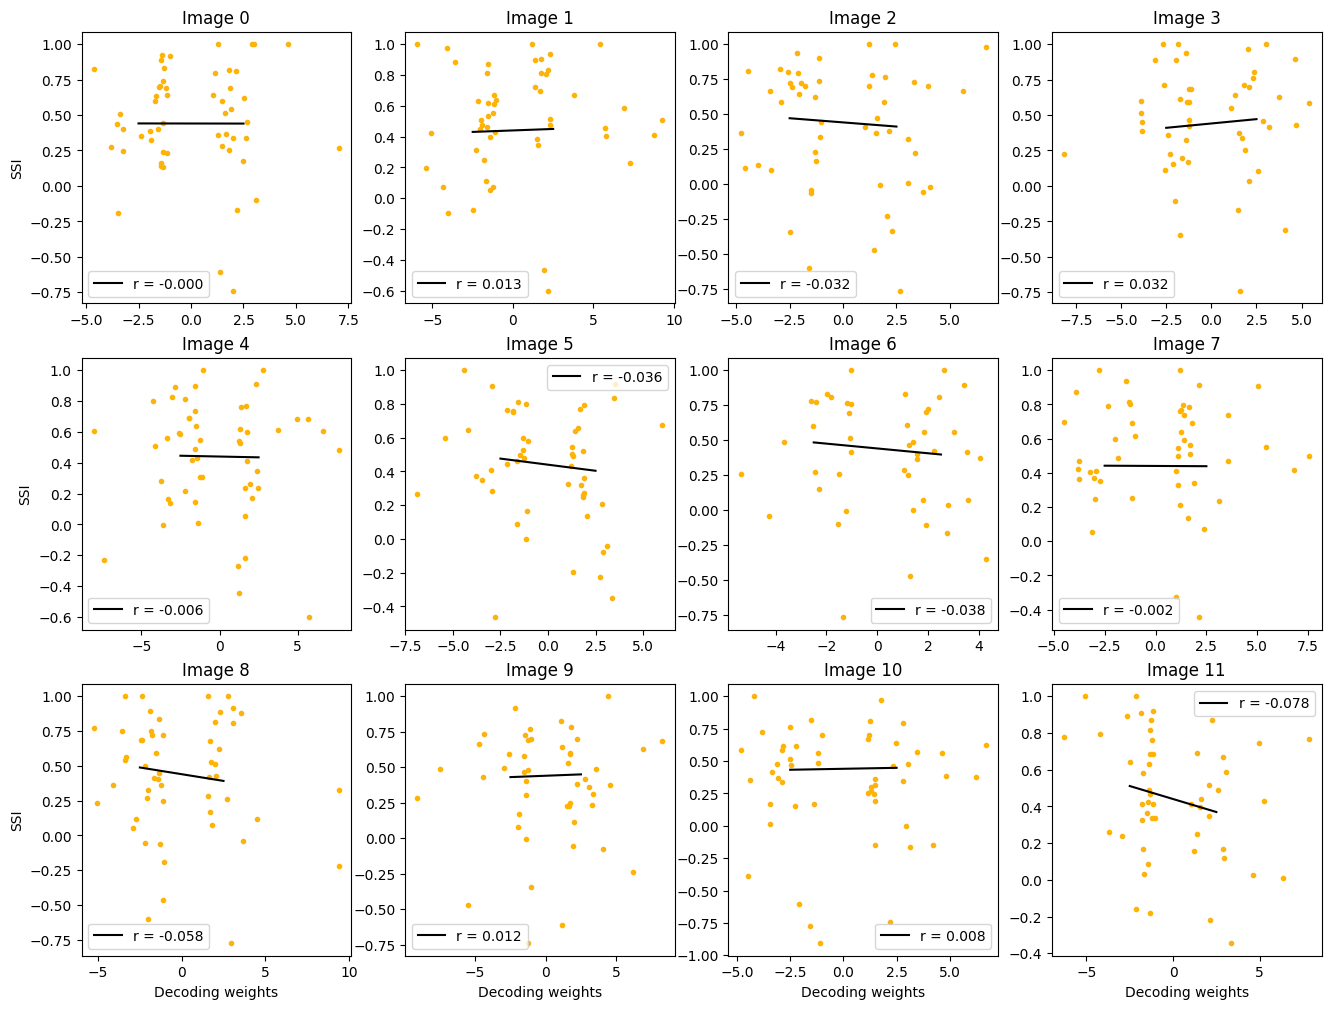

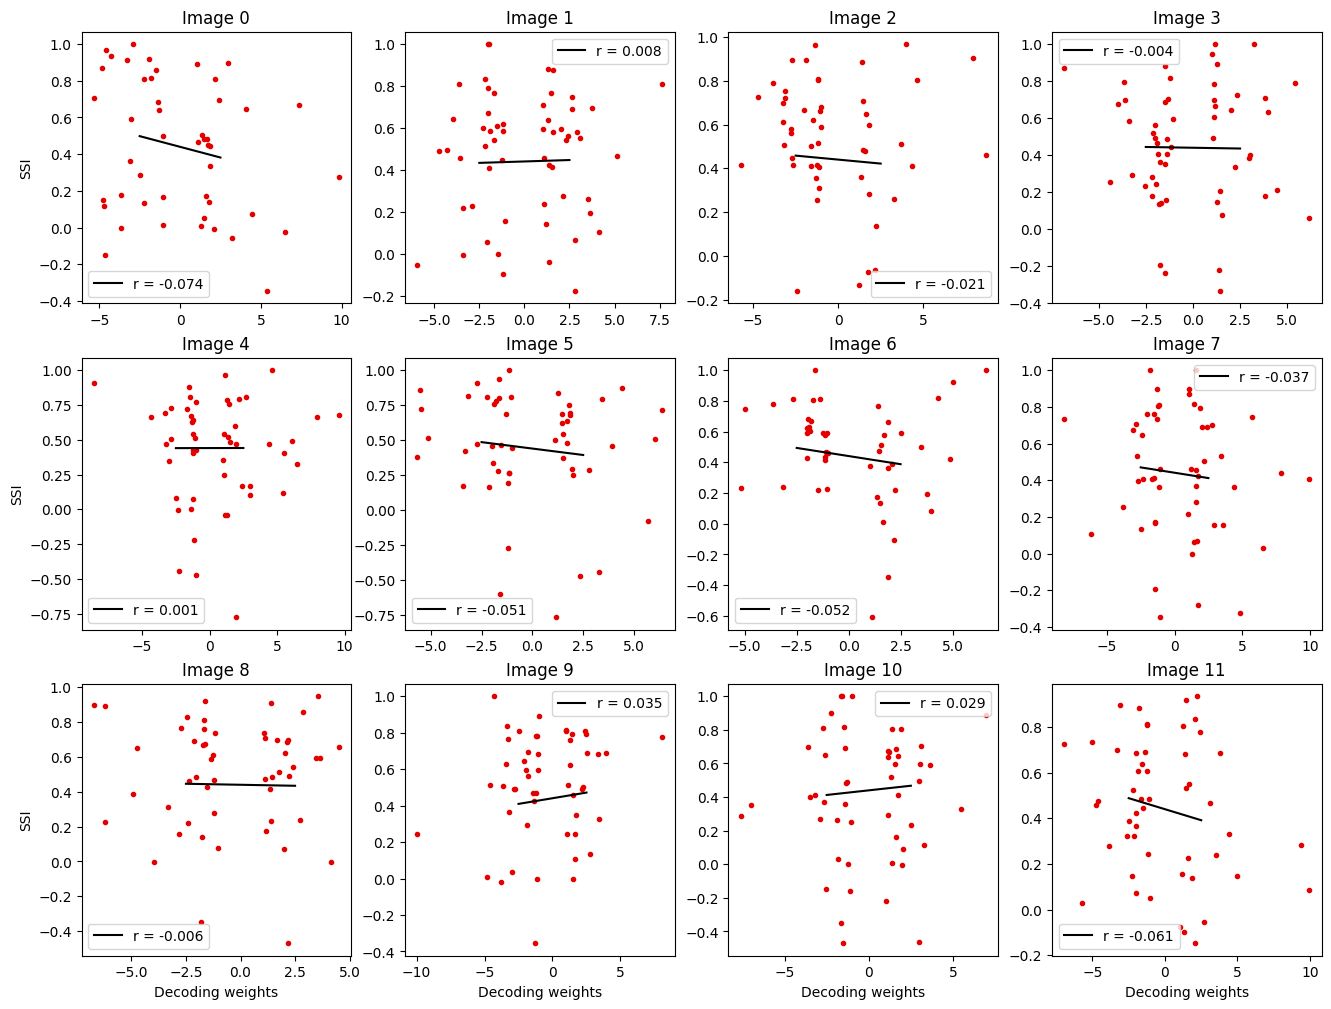

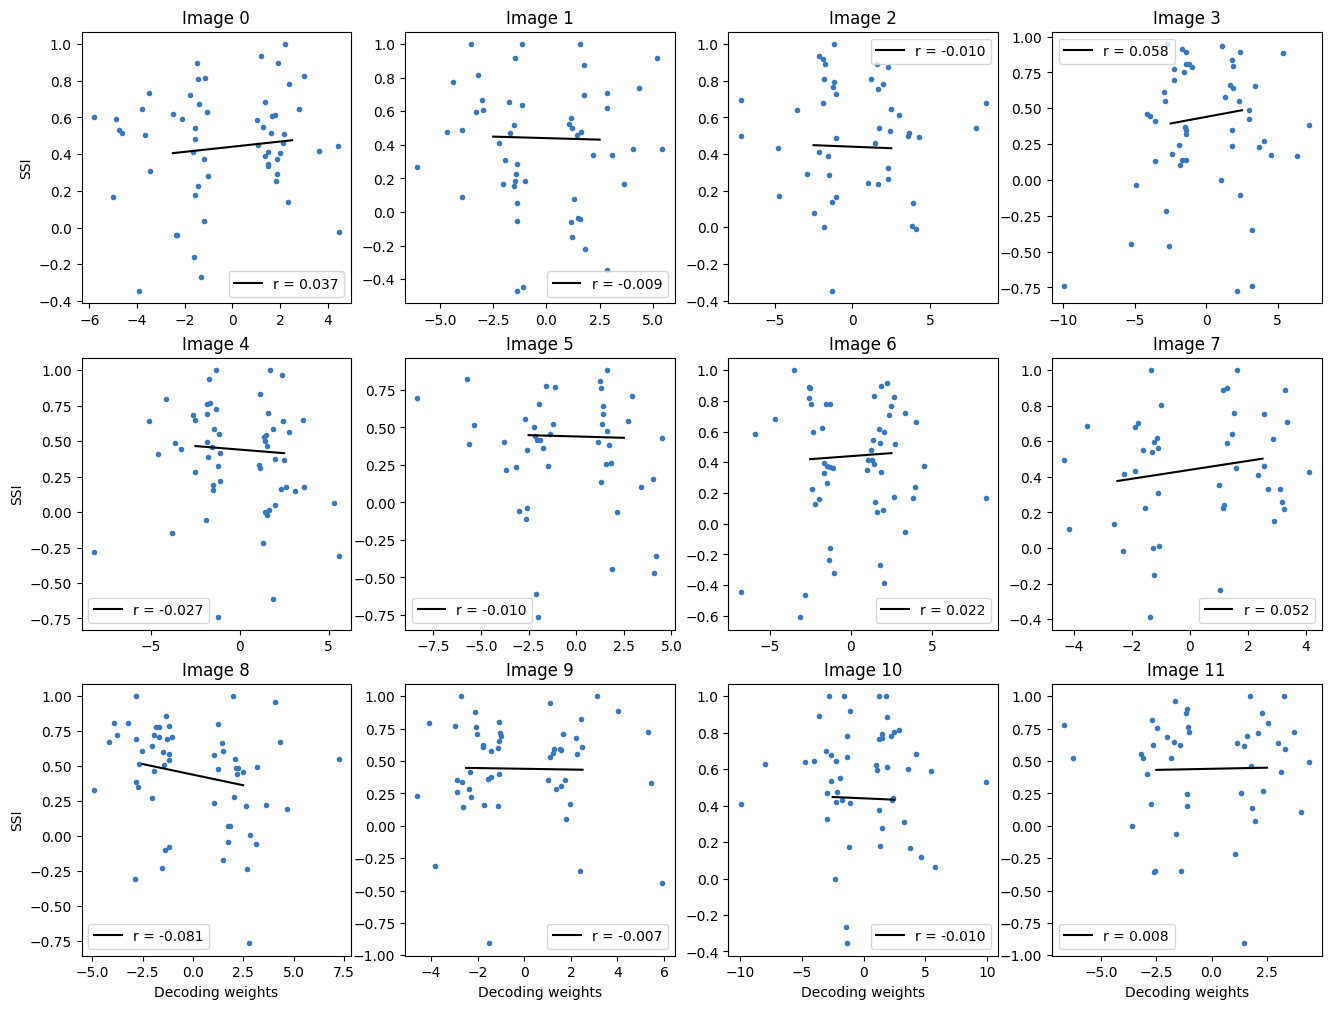

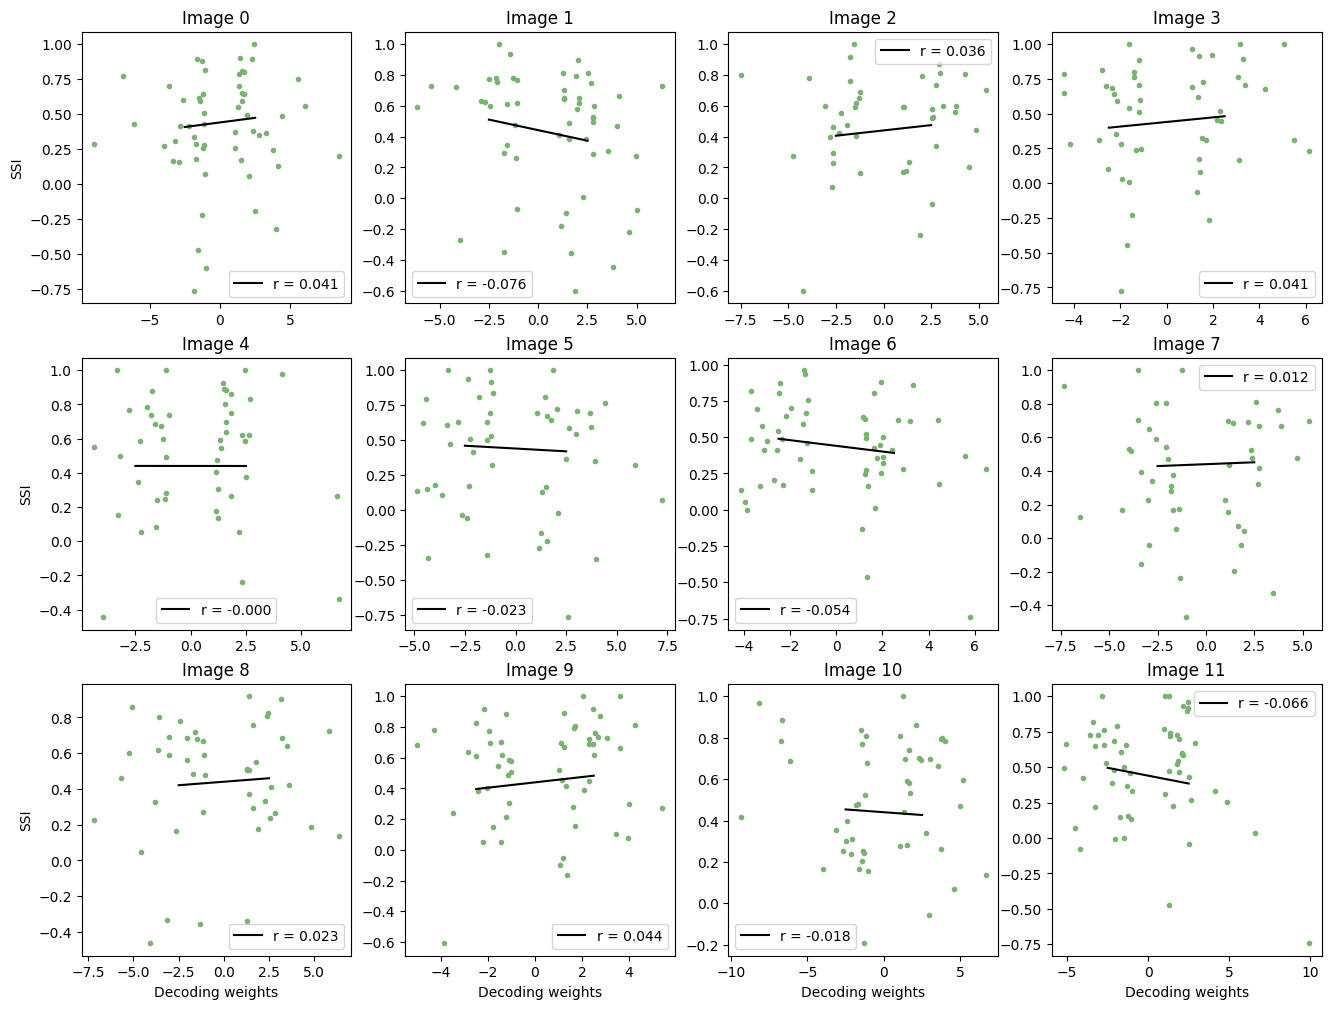

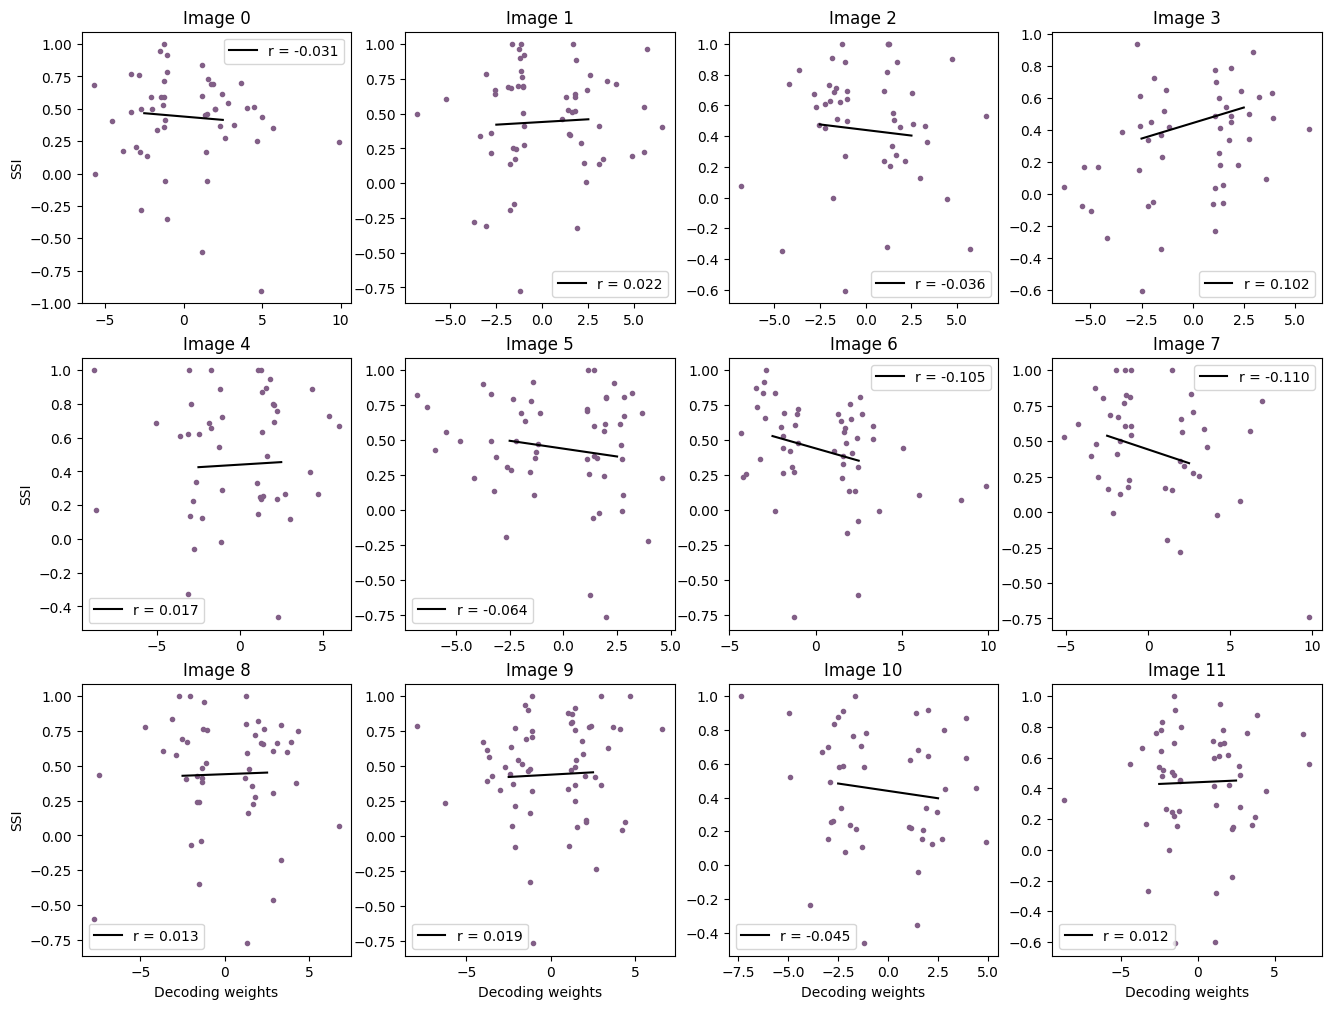

In [21]:
## Plot scatter of decoding weights vs ssi


informative_neurons_kfold = []
neurons_numimgs = []

plane = 2
##===== Perform decoding of natural images per plane =====##
for ii in range(5):

    dw = np.array(decoding_weights_z[ii]).T

    fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(16, 12))

    for jj in range(nStim):
        ax = axes[jj//4,jj%4]
        ax.set_title(f'Image {jj}')

        x = dw[:,jj]; y = ssi_list[plane-1]
        indy = np.where((x < -1) | (x > 1))[0]
        ax.scatter(x[indy],y[indy],marker='.',color=cc[ii])

        slope, intercept, r, p, se = st.linregress(x, y)
        
        x_plot = np.arange(-2.5,2.51,0.01)

        ax.plot(x_plot,slope*x_plot+intercept,'-k',label=f'r = {r:.3f}')

        if jj % 4 == 0:
            ax.set_ylabel('SSI')

        if jj//4 == 2:
            ax.set_xlabel('Decoding weights')

        ax.legend()

    # plt.savefig(path.join(PlotDir,f'dwz-vs-ssi_naturalscences_{method}{classifier}_fold{ii}_{mouse_id}_{col}{vol}.pdf'))


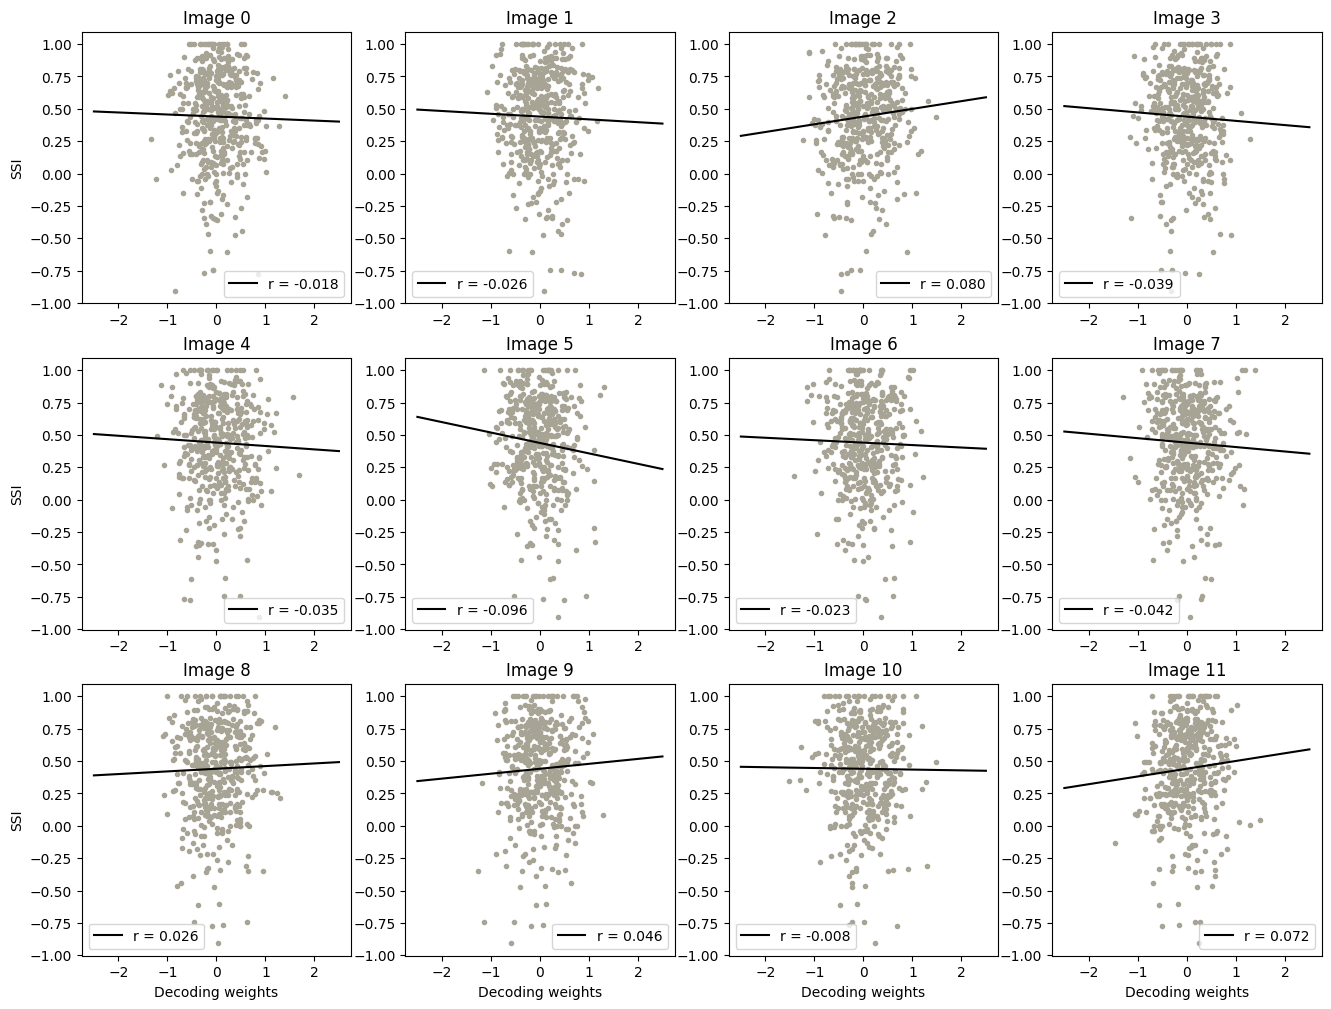

In [29]:


dw = np.mean(decoding_weights_z,axis=0).T

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(16, 12))

for jj in range(nStim):
    ax = axes[jj//4,jj%4]
    ax.set_title(f'Image {jj}')

    x = dw[:,jj]; y = ssi_list[plane-1]
    ax.scatter(x,y,marker='.',color=cc[8])

    slope, intercept, r, p, se = st.linregress(x, y)
    
    x_plot = np.arange(-2.5,2.51,0.01)

    ax.plot(x_plot,slope*x_plot+intercept,'-k',label=f'r = {r:.3f}')

    if jj % 4 == 0:
        ax.set_ylabel('SSI')

    if jj//4 == 2:
        ax.set_xlabel('Decoding weights')

    ax.legend()

plt.savefig(path.join(PlotDir,f'dwz-vs-ssi_naturalscences_{method}{classifier}_mean-fold_{mouse_id}_{col}{vol}.pdf'))


In [14]:
## How do we take these decoding weights to ascertain which neurons are informative for decoding?
from functools import reduce
informative_neurons_indices = reduce(np.intersect1d, (informative_neurons_kfold))

# informative_neurons_indices = np.unique(np.concatenate(informative_neurons_kfold))
noninformative_neurons_indices = np.setdiff1d(np.arange(nNeurons),informative_neurons)

print(len(informative_neurons_indices))


54


In [15]:
ssi_list = []

roiIDs = roi_list[plane-1]
for index in informative_neurons_indices:
    iN = roiIDs[index]
    key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
    ssi_list.append(metrics_13.loc[key]['ssi'])
    
ssi_list2 = []

roiIDs = roi_list[plane-1]
for index in noninformative_neurons_indices:
    iN = roiIDs[index]
    key = f'M{mouse_id}_{col}{vol}_{plane}_{iN}'
    ssi_list2.append(metrics_13.loc[key]['ssi'])  
    # print(metrics_13.loc[key]['dgw_frac_responsive_trials'],metrics_13.loc[key]['dgf_frac_responsive_trials'],metrics_13.loc[key]['ssi'])

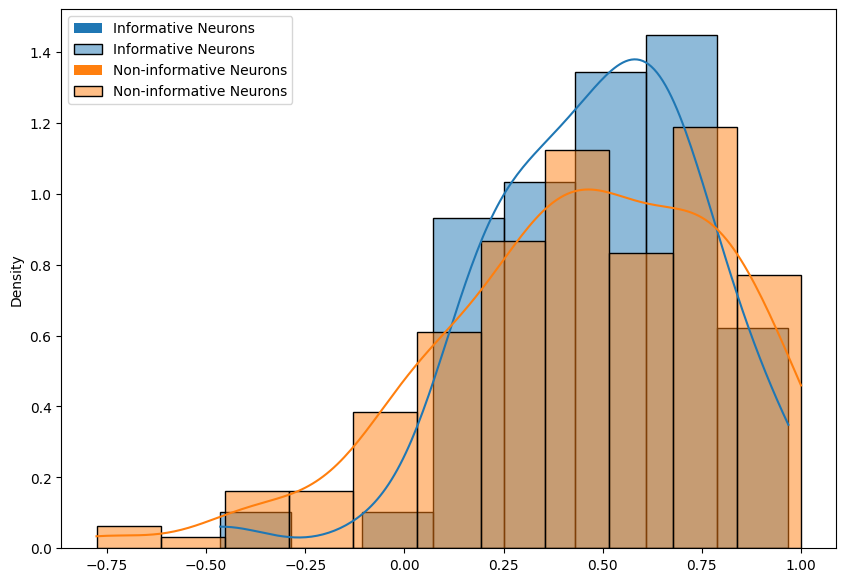

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
b1 = sns.histplot(ssi_list,ax=ax,stat='density',kde=True,label='Informative Neurons')
b2 = sns.histplot(ssi_list2,ax=ax,stat='density',kde=True,label='Non-informative Neurons')

ax.legend()


In [45]:
b1.bbox[0]

TypeError: 'TransformedBbox' object is not subscriptable

In [40]:
dir(b1)

['ArtistList',
 '_AxesBase__clear',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_map',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_errorevery_to_mask',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_fully_clipped_to_axes',
 '_

In [77]:
metrics_duplicates = metrics_13.loc[metrics_13['has_duplicate']]

for index,row in metrics_duplicates.iterrows():
    if key in row['duplicate_rois'].split(', '):
        print(row['key'])

['M409828_13_4_108', 'M409828_13_5_87', 'M409828_13_6_553']

In [56]:
key in metrics_13['duplicate_rois'].values

False

In [57]:
np.concatenate(metrics_13['duplicate_rois'].values)

ValueError: zero-dimensional arrays cannot be concatenated